# 強化学習 3日目 @ Summer School 数理物理 2021
## Q learningとSARSAの比較
- オフポリシー型のQ学習とオンポリシー型のSARSAを学習の様子を比較して、両者の違いを確認する
***
Tetsuro Morimura, 2021

# 準備

### パッケージのインポート

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# 環境の設定

### MDPクラスの定義
- Environment classのスーパークラス

In [2]:
## Define MDP (Markov Decision Process) class
class MDP:
    def __init__(self, state_set, action_set, init_prob, trans_prob, reward_fun):
        self.state_set   = state_set
        self.action_set  = action_set
        self.nstate      = len(state_set)
        self.naction     = len(action_set)
        self._init_prob  = init_prob
        self._trans_prob = trans_prob   #d1:state, d2:action, d3:next_state
        self._reward_fun = reward_fun   #d1:state, d2:action
        self._state      = None
        self._action     = None
        self._reward     = None
    def set_state(self, state):
        self._state  = state
    def set_action(self, action):
        self._action = action
    def get_trans_matrix(self, state):
        return np.array(self._trans_prob[state])
    def get_reward_vec(self, state):
        return np.array(self._reward_fun[state])
    def get_state(self):
        return self._state
    def get_action(self):
        return self._action
    def get_reward(self):
        return self._reward_fun[self._state][self._action]
    def get_value_fun(self, gamma, policy): 
        r_s  = np.zeros(self.nstate)
        P_ss = np.zeros((self.nstate,self.nstate))
        if np.shape(policy) == (self.nstate,): # deterministic policy
            for s in range(self.nstate):
                r_s[s]  = self.get_reward_vec(s) [policy[s]]
                P_ss[s] = self.get_trans_matrix(s)[policy[s]]
        else: # stochastic policy
            policy = np.array(policy)
            for s in range(self.nstate):
                r_s[s]  = np.inner(policy[s], self.get_reward_vec(s))
                P_ss[s] = np.inner(policy[s], self.get_trans_matrix(s).T)
        value_fun = np.linalg.solve(np.eye(self.nstate)-gamma*P_ss, r_s)  # solve Ax = b 
        return value_fun
    def get_q_value_fun(self, gamma, policy):
        value_fun   = self.get_value_fun(gamma, policy)
        q_value_fun = np.zeros((self.nstate,self.naction))
        for s in range(self.nstate):
            r_vector       = self.get_reward_vec(s) 
            P_matrix       = self.get_trans_matrix(s) # d1:action, d2:next_state
            q_value_fun[s] = r_vector + gamma * np.inner(value_fun, P_matrix)
        return q_value_fun
    def reset(self):
        init_state  = np.random.choice(self.state_set, p=self._init_prob)
        self._state  = init_state
        self._action = None
        return init_state
    def step(self, action=None):
        state = self.get_state()
        if action is None:
            action = self.get_action()
        else:
            self.set_action(action)
        if state is None or action is None:
            raise Exception("'state' or/and 'action' is not set!")
        next_state   = np.random.choice(self.state_set, p=self._trans_prob[state][action])
        reward       = self.get_reward()
        self._state  = next_state
        self._reward = reward
        self._action = None
        return next_state, reward

### 環境クラスの定義
- MDPクラスを継承
- 環境が未知であることを保証するため、一部のメソッドを遮蔽

In [3]:
## Environment
class Environment(MDP):
    def set_state(self):
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_trans_matrix(self):
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_reward_vec(self):
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_value_fun(self): 
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_q_value_fun(self): 
        raise Exception("This method is not available!") #自由に状態をリセットできないので

### 環境インスタンスの生成
 - 3状態2行動MDPの「損して得とれ課題」

In [4]:
## Generate Environment (env) instance
state_set  = [0,1,2]
action_set = [0,1]
init_prob  = [0.6, 0.3, 0.1]
trans_prob = np.zeros(len(state_set)*len(action_set)*len(state_set)).reshape(len(state_set), len(action_set), len(state_set)) #d1:state, d2:action, d3:next state
trans_prob[0][0] = [1,   0,   0]
trans_prob[0][1] = [0.5, 0.5, 0]
trans_prob[1][0] = [1,   0,   0] 
trans_prob[1][1] = [0,   0.5, 0.5]
trans_prob[2][0] = [0,   1,   0]
trans_prob[2][1] = [1,   0,   0]
reward_fun       = [[1.0,   0.0],
                    [0.0, -10.0],
                    [1.0, 30.0],]   #d1:state, d2:action

mdp = MDP(state_set, action_set, init_prob, trans_prob, reward_fun) # 環境未知の時、agentからのアクセスNG
env = Environment(state_set, action_set, init_prob, trans_prob, reward_fun)
del state_set, action_set, init_prob, trans_prob, reward_fun

### 動作確認
- 状態集合，行動集合の確認

In [5]:
print('state set: ',  env.state_set)
print('action set:', env.action_set)

state set:  [0, 1, 2]
action set: [0, 1]


- 環境を初期化して、初期観測を確認

In [6]:
init_state = env.reset() ## 環境の初期化
print('initial state:', init_state)

initial state: 1


- エピソード生成（行動は乱択）

In [7]:
init_state  = env.reset() 

max_timestep = 10
timestep     = 0

print('initial state:', init_state)

while timestep < max_timestep:
    action             = np.random.choice(env.action_set) ## ランダムな行動選択
    next_state, reward = env.step(action) ## 行動を環境に入力して、次状態と報酬を受け取る
    # print
    print('----------- time step {} --------'.format(timestep))
    print('action:', action,
          'next state:', next_state,
          'reward:', reward)
    # update timespte
    timestep          +=1
    

initial state: 2
----------- time step 0 --------
action: 0 next state: 1 reward: 1.0
----------- time step 1 --------
action: 0 next state: 0 reward: 0.0
----------- time step 2 --------
action: 1 next state: 1 reward: 0.0
----------- time step 3 --------
action: 0 next state: 0 reward: 0.0
----------- time step 4 --------
action: 0 next state: 0 reward: 1.0
----------- time step 5 --------
action: 0 next state: 0 reward: 1.0
----------- time step 6 --------
action: 0 next state: 0 reward: 1.0
----------- time step 7 --------
action: 0 next state: 0 reward: 1.0
----------- time step 8 --------
action: 1 next state: 1 reward: 0.0
----------- time step 9 --------
action: 0 next state: 0 reward: 0.0


# エージェントの設定
### RLエージェントクラスの定義
- アブストラクトクラス

In [8]:
## Abstract RL agent class 
class Agent():
    def __init__(self, state_space, action_space, gamma=0.9):
        self.state_space  = state_space
        self.action_space = action_space
        self.gamma        = gamma
        self.experiences  = []
        self.timestep     = 0

    def reset(self):
        # エージェントの初期化
        raise NotImplementedError("class is abstract.") 

    def add_experience(self, state, action, reward, next_state):
        # 経験データの追加
        raise NotImplementedError("class is abstract.") 

    def policy(self, state):
        # 行動選択
        raise NotImplementedError("class is abstract.")

    def learning(self):
        # 学習
        raise NotImplementedError("class is abstract.")

### Q学習エージェントクラスの実装
- Agentクラスを継承
- Q関数: Table形式
- 方策: Epsilon-greedy

In [9]:
## Q-learning agent (tabular version with epsilon-greedy policy)
class TabularQlearning(Agent):
    def __init__(self, state_space, action_space, gamma=0.9, epsilon=[100., 100.],alpha=[200., 200.]):
        super().__init__(state_space, action_space, gamma)
        self.nstate  = len(state_space) 
        self.naction = len(action_space)
        self.q_fun   = np.random.randn(self.nstate, self.naction) / 1000
        self.epsilon = epsilon # hyper-param for e-greedy
        self.alpha   = alpha   # hyper-hparam for learning rate

    def reset(self, q_bias=0.):
        self.timestep    = 0
        self.experiences = []
        self.q_fun       = np.random.randn(self.nstate, self.naction) / 1000 + q_bias


    def add_experience(self, state, action, reward, next_state):
        self.experiences = [state, action, reward, next_state]


    def policy(self, state): #Epsilon-Greedy Agent Policy
        # epsilonの設定
        if isinstance(self.epsilon, list) != True:
            epsilon = self.epsilon
        else:
            epsilon = self.epsilon[0] / (self.timestep + self.epsilon[1])
        # 行動選択
        if epsilon <= np.random.uniform():
            action = np.argmax(self.q_fun[state])
        else:
            action = np.random.choice(self.naction)
        return action


    def learning_rate(self):
        if isinstance(self.alpha, list) != True:
            learning_rate = self.alpha
        else:
            learning_rate = self.alpha[0] / (self.timestep + self.alpha[1])
        return learning_rate


    def learning(self):
        state, action, reward, next_state = self.experiences
        
        td_error = reward + self.gamma * np.max(self.q_fun[next_state]) - self.q_fun[state][action]
        self.q_fun[state][action] += self.learning_rate() * td_error 

### SARSAエージェントクラスの実装
- Agentクラスを継承
- Q関数: Table形式
- 方策: Epsilon-greedy

In [10]:
## SARSA-learning agent (tabular version with epsilon-greedy policy)
class TabularSARSA(Agent):
    def __init__(self, state_space, action_space, gamma=0.9, epsilon=[100., 100.],alpha=[200., 200.]):
        super().__init__(state_space, action_space, gamma)
        self.nstate  = len(state_space) 
        self.naction = len(action_space)
        self.q_fun   = np.random.randn(self.nstate, self.naction) / 1000
        self.epsilon = epsilon # hyper-param for e-greedy
        self.alpha   = alpha   # hyper-hparam for learning rate

    def reset(self, q_bias=0.):
        self.timestep    = 0
        self.experiences = []
        self.q_fun       = np.random.randn(self.nstate, self.naction) / 1000 + q_bias


    def add_experience(self, state, action, reward, next_state):
        self.experiences.append([state, action, reward, next_state])
        if len(self.experiences) > 2: 
            del self.experiences[0]  #delete old experiences

    def policy(self, state): #Epsilon-Greedy Agent Policy
        # epsilonの設定
        if isinstance(self.epsilon, list) != True:
            epsilon = self.epsilon
        else:
            epsilon = self.epsilon[0] / (self.timestep + self.epsilon[1])
        # 行動選択
        if epsilon <= np.random.uniform():
            action = np.argmax(self.q_fun[state])
        else:
            action = np.random.choice(self.naction)
        return action


    def learning_rate(self):
        if isinstance(self.alpha, list) != True:
            learning_rate = self.alpha
        else:
            learning_rate = self.alpha[0] / (self.timestep + self.alpha[1])
        return learning_rate


    def learning(self):
        if len(self.experiences) == 2:
            state, action, reward, _      = self.experiences[0]
            next_state, next_action, _, _ = self.experiences[1]
        
            td_error = reward + self.gamma * self.q_fun[next_state][next_action] - self.q_fun[state][action]
            self.q_fun[state][action] += self.learning_rate() * td_error 

# 実験

### 実験パラメータの設定

In [11]:
## Set parameters

# param for experiment
n_experiment = 500    # num of experiments
n_timestep   = 3200  # length of episode

# param for agent
gamma       = 0.9   # discounting rate
alpha       = 0.2   # learning rate
epsilon     = 0.5   # epsilon of e-greedy
q_val_bias  = 50.   # bias for optimisitic initilization of Q-value

### 学習

- Q学習

In [12]:
## Q Learning

# generate agent
agent = TabularQlearning(env.state_set, env.action_set, gamma=gamma, alpha=alpha, epsilon=epsilon)

# prep for storing results
rewards_list_qlearn = np.zeros((n_timestep, n_experiment))

# main
print("Q-learning ...", end="")
for n in range(n_experiment):
    if n%10==0: print(".", end="")

    # reset env, agent, and reward series
    state = env.reset()
    agent.reset(q_bias=q_val_bias) 
    rewards = []

    for t in range(n_timestep):
        # interaction with env
        action             = agent.policy(state)
        next_state, reward = env.step(action)
        # update agent
        agent.add_experience(state, action, reward, next_state)
        agent.learning()
        agent.timestep += 1
        # update state
        state = next_state
        # store
        rewards.append(reward)

    # store results
    rewards_list_qlearn[:,n] = rewards

print(" finish !")

Q-learning ..................................................... finish !


- SARSA学習

In [13]:
## SARSA Learning

# generate agent
agent = TabularSARSA(env.state_set, env.action_set, gamma=gamma, alpha=alpha, epsilon=epsilon)

# prep for storing results
rewards_list_sarsa = np.zeros((n_timestep, n_experiment))

# main
print("SARSA ...", end="")
for n in range(n_experiment):
    if n%10==0: print(".", end="")

    # reset env, agent, and reward series
    state = env.reset()
    agent.reset(q_bias=q_val_bias) 
    rewards = []

    for t in range(n_timestep):
        # interaction with env
        action             = agent.policy(state)
        next_state, reward = env.step(action)
        # update agent
        agent.add_experience(state, action, reward, next_state)
        agent.learning()
        agent.timestep += 1
        # update state
        state = next_state
        # store
        rewards.append(reward)

    # store results
    rewards_list_sarsa[:,n] = rewards

print(" finish !")

SARSA ..................................................... finish !


### 学習結果の可視化

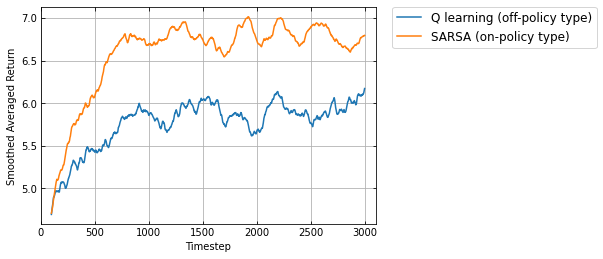

In [14]:
## Visualization
t_lim       = 3100
window_size = 200

# transform rewards to returns
return_t_list_qlearn = np.zeros((t_lim,n_experiment))
return_t_list_sarsa  = np.zeros((t_lim,n_experiment))
for t in reversed(range(t_lim)):
    if t==t_lim-1:
        geom = gamma ** np.array(range(n_timestep-t))
        return_t_list_qlearn[t] = np.dot(geom, rewards_list_qlearn[t:,])
        return_t_list_sarsa[t]  = np.dot(geom, rewards_list_sarsa[t:,])
    else:
        return_t_list_qlearn[t] = rewards_list_qlearn[t] + gamma * return_t_list_qlearn[t+1]
        return_t_list_sarsa[t]  = rewards_list_sarsa[t]  + gamma * return_t_list_sarsa[t+1]

# compute smoothed averated return
v = np.ones(window_size)/window_size # 移動平均をとるための配列vを設定
return_t_list_qlearn = np.convolve( np.mean(return_t_list_qlearn, axis=1), v, mode='valid') 
return_t_list_sarsa  = np.convolve( np.mean(return_t_list_sarsa,  axis=1), v, mode='valid') 

# plot averaged return over timestep
xlim = np.array(range(window_size-1,t_lim)) - window_size/2
plt.plot(xlim, return_t_list_qlearn, label='Q learning (off-policy type)')
plt.plot(xlim, return_t_list_sarsa, label='SARSA (on-policy type)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.xlabel('Timestep')
plt.ylabel('Smoothed Averaged Return')
plt.tick_params(top = True, right = True, direction = 'in')
plt.grid(which='both')
#plt.ylim(4,8)
plt.xlim(0,t_lim)
plt.show()

### 価値関数の計算
- mdpクラス (<- agentは使用禁止)を使用

In [15]:
## e-greedy policy
# param
eps = epsilon

# set policy
p_greedy     = 1 - eps/2
p_nongreedy  = eps/2
e_policy_001 = [[p_greedy,p_nongreedy], [p_greedy,p_nongreedy], [p_nongreedy,p_greedy]]
e_policy_011 = [[p_greedy,p_nongreedy], [p_nongreedy,p_greedy], [p_nongreedy,p_greedy]]
e_policy_111 = [[p_nongreedy,p_greedy], [p_nongreedy,p_greedy], [p_nongreedy,p_greedy]]
d_policy_opt = [[0., 1.], [0., 1.], [0., 1.]]

# print
print('V of e_policy_001: ', mdp.get_value_fun(gamma, e_policy_001))
#print('V of e_policy_011: ', mdp.get_value_fun(gamma, e_policy_011))
print('V of e_policy_111: ', mdp.get_value_fun(gamma, e_policy_111))
print('Optimal V:         ', mdp.get_value_fun(gamma, d_policy_opt))
print('')
print('Q of e_policy_001: \n', mdp.get_q_value_fun(gamma, e_policy_001))
#print('Q of e_policy_011: \n', mdp.get_q_value_fun(gamma, e_policy_011))
print('Q of e_policy_111: \n', mdp.get_q_value_fun(gamma, e_policy_111))
print('Optimal Q:         \n',   mdp.get_q_value_fun(gamma, d_policy_opt))

V of e_policy_001:  [ 6.61694888  5.83201456 28.52864377]
V of e_policy_111:  [ 1.99194641  1.84141201 24.50888153]
Optimal V:          [13.0977131  16.00831601 41.78794179]

Q of e_policy_001: 
 [[ 6.955254    5.60203355]
 [ 5.955254    5.46229625]
 [ 6.2488131  35.955254  ]]
Q of e_policy_111: 
 [[ 2.79275177  1.72501129]
 [ 1.79275177  1.85763209]
 [ 2.65727081 31.79275177]]
Optimal Q:         
 [[12.78794179 13.0977131 ]
 [11.78794179 16.00831601]
 [15.40748441 41.78794179]]


### 考察
e-greedy方策(e=0.5)におけるoptimal greedy action=[0,0,1]と、決定的方策での optimal action =[1,1,1]は異なる。
- Q学習(オフポリシー型)は真のoptimal actionを学習
 - 実際はbehavior policyに従い行動選択するが、behavior policyがQ学習のtarget policyと大きく異なる場合、今回の例のようにパフォーマンスが出ないこともある
- SARSA(オンポリシー型)はbehaivior policyにおけるoptimal greedy actionを学習
 - 求まる方策がbehavior policyに依存
 - behavior policyが決定的方策と大きく異なると、一般に最適方策が求まらない

 以上より、以下のように使い分けるのが良いだろう
 - 学習期間終了後のパフォーマンスを重視　⇒　Q学習 (off-policy)
 - 学習期間中のパフォーマンスも大切　⇒　SARSA (on-policy)